# Financial News Sentiment Classifier (Portfolio)
**Notebook 01 — Train baseline sentiment model on Financial PhraseBank**

**Goal:** Train a transparent, reproducible baseline sentiment classifier for short financial texts.  
This model will later score daily headlines in Notebook 02 to build a market prediction dataset.


## Dataset & Rationale
- **Dataset:** Financial PhraseBank (Malo et al., 2014), a widely used labelled corpus of short financial statements.
- **Task:** Multi-class sentiment classification (positive / neutral / negative).
- **Why baseline:** TF–IDF + Logistic Regression is fast, robust, and highly interpretable for short text. It’s perfect for a first, defensible portfolio model.


In [3]:
# Purpose: Load the real dataset, sanity-check it, and prepare a clean training frame.

import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Make sure outputs can be saved
os.makedirs("../models", exist_ok=True)

DATA_PATH = "../data/raw/financial_phrasebank.csv"  # <-- ensure your file is here
SEED = 42

pd.set_option("display.max_colwidth", 120)


## Load and Inspect the Dataset
We load the CSV, verify columns, check class balance, and do minimal cleaning.  
(We keep pre-processing light so the baseline remains transparent.)


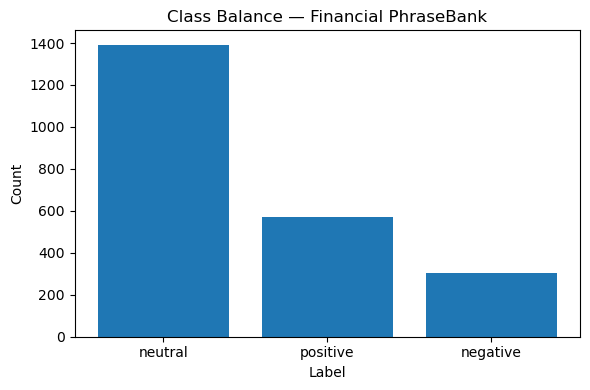

In [12]:
import matplotlib.pyplot as plt

counts = df['label'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Balance — Financial PhraseBank")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [11]:
# Load the dataset; expected columns: 'text', 'label'
df = pd.read_csv(DATA_PATH)

# Validate essential columns
expected_cols = {"sentence", "label"}
missing = expected_cols - set(df.columns.str.lower())
if missing:
    raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

# Normalize column names just in case
df = df.rename(columns={c: c.lower() for c in df.columns})

# Basic cleaning: drop NA, strip whitespace
df = df.dropna(subset=["sentence", "label"]).copy()
df["sentence"]  = df["sentence"].astype(str).str.strip()
df["label"] = df["label"].astype(str).str.strip().str.lower()

# (Optional) Standardize label spelling variants
label_map = {
    "pos": "positive", "neg": "negative", "neu": "neutral",
    "positive": "positive", "negative": "negative", "neutral": "neutral"
}
df["label"] = df["label"].map(lambda x: label_map.get(x, x))

# Show quick stats
print("Rows:", len(df))
print(df["label"].value_counts())
df.head(5)


Rows: 2264
label
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


,sentence,label
0,The value of the order is USD 2.2 mn .,neutral
1,"YIT lodged counter claims against Neste Oil totaling some EUR25m , primarily based on work carried out under the con...",negative
2,"Rohwedder Group is an automotive supplies , telecommunications and electronics industry provider for customers in Eu...",neutral
3,Nokia was up 0.12 pct to 16.70 eur after kicking off the morning in negative territory .,positive
4,"The Group owns and operates a fleet of more than 800dwt , while container capacity is 17,000 TEUs , and manages a di...",neutral


## Train/Validation Split (Stratified)
We preserve class ratios using a **stratified** split to get fair metrics across classes.


In [6]:
# Keep columns clean and split the data into training and validation sets.
df = df.dropna(subset=["sentence","label"]).reset_index(drop=True)

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    df["sentence"],                # input texts
    df["label"],               # target labels
    test_size=0.3,             # 30% for validation
    random_state=42,           # reproducible split
    stratify=df["label"]       # keep class balance similar
)

len(X_train), len(X_valid)


(1584, 680)

##  Model Choice: TF–IDF + Logistic Regression
- **TF–IDF**: Converts text to weighted n-gram features (captures unigrams & bigrams).
- **Logistic Regression (multinomial)**: Strong linear baseline; interpretable; fast to train.
- **Class weights**: `balanced` to handle label imbalance.


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# A simple, strong baseline: TF-IDF features + Logistic Regression classifier
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=300))
])

# Train
pipe.fit(X_train, y_train)

# Evaluate
pred = pipe.predict(X_valid)
print(classification_report(y_valid, pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_valid, pred))


              precision    recall  f1-score   support

    negative       0.94      0.49      0.65        91
     neutral       0.84      0.98      0.91       418
    positive       0.84      0.71      0.77       171

    accuracy                           0.85       680
   macro avg       0.87      0.73      0.78       680
weighted avg       0.85      0.85      0.84       680

Confusion Matrix:
 [[ 45  30  16]
 [  1 410   7]
 [  2  47 122]]


## How to Read These Metrics
- **Precision**: When the model says *positive*, how often is it correct?
- **Recall**: Of all true *positive* texts, how many did we catch?
- **F1**: Harmonic mean of precision & recall; good single-number summary.
- **Class balance matters**: If Neutral dominates, `class_weight='balanced'` helps the minority classes.


In [8]:
import joblib, os
os.makedirs("../models", exist_ok=True)
joblib.dump(pipe, "../models/sentiment_baseline.pkl")
print("Saved → ../models/sentiment_baseline.pkl")


Saved → ../models/sentiment_baseline.pkl


##  Model Card (Summary)
- **Name:** Financial PhraseBank Sentiment (TF–IDF + Logistic Regression)
- **Intended use:** Score short financial headlines/sentences as *positive*, *neutral*, or *negative*.
- **Data:** Financial PhraseBank (Malo et al., 2014). Short finance-focused statements. https://www.kaggle.com/code/kajuyerim/lora-guide-on-llama3-1-8b-instruct/notebook [accessed 30 Oct 2025].
- **Limitations:** Domain-specific; may not generalize to slang, long articles, or non-English text.
- **Ethics/Use:** For educational/analytical use only; do not use as sole signal for trading decisions.
